In [183]:
import requests
import pandas as pd
import numpy as np
import wikipedia as w
import bs4
import networkx as nx
import geopy

url = "https://en.wikipedia.org/wiki/2023_Formula_One_World_Championship"
r = requests.get(url)

dfs = pd.read_html(r.text)
races = dfs[1].head(-1)
races["Coordinates"] = [(0,0) for x in races.index]

<ipython-input-183-1262c974d856>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  races["Coordinates"] = [(0,0) for x in races.index]


In [185]:
def convert_coordinates(x):
    return tuple(float(y) for y in x.split(" / ")[-1].split("; "))

def get_infobox(url):
    r = requests.get(url)
    site = bs4.BeautifulSoup(r.text)
    infobox = site.find('table', {'class': 'infobox'})
    items_html = infobox.find_all("tr")
    items_dict = {}
    for x in items_html:
        try:
            key = x.find("th").text
            value = x.find("td").text
            items_dict[key] = value
        except AttributeError:
            pass

    if "Coordinates" in items_dict.keys():
        items_dict["Coordinates"] = convert_coordinates(items_dict["Coordinates"])
    else:
        try:
            items_dict["Coordinates"] = convert_coordinates(infobox.find("span", {"class": "geo"}).text)
        except AttributeError:
            pass
    
    return items_dict

In [186]:
for i, x in races.iterrows():
    name = x["Circuit"].split(",")[0]
    if name == "Las Vegas Street Circuit":
        search = ["Las Vegas Strip"]
    else:
        search = w.search(name)
    track = w.page(search[0], auto_suggest=False)
    info = get_infobox(track.url)
    x["Coordinates"] = info["Coordinates"]
    races.loc[i] = x

/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/usr/local/lib/python3.9/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


In [215]:
races

,Round,Grand Prix,Circuit,Race date,Coordinates
0,1,Bahrain Grand Prix,"Bahrain International Circuit, Sakhir",5 March,"(26.0325, 50.51056)"
1,2,Saudi Arabian Grand Prix,"Jeddah Corniche Circuit, Jeddah",19 March,"(21.63194, 39.10444)"
2,3,Australian Grand Prix,"Albert Park Circuit, Melbourne",2 April,"(-37.84972, 144.96833)"
3,4,Azerbaijan Grand Prix,"Baku City Circuit, Baku",30 April,"(40.3725, 49.85333)"
4,5,Miami Grand Prix,"Miami International Autodrome, Miami Gardens, ...",7 May,"(25.95806, -80.23889)"
5,6,Emilia Romagna Grand Prix,"Imola Circuit, Imola",21 May,"(44.34111, 11.71333)"
6,7,Monaco Grand Prix,"Circuit de Monaco, Monaco",28 May,"(43.73472, 7.42056)"
7,8,Spanish Grand Prix,"Circuit de Barcelona-Catalunya, Montmeló",4 June,"(41.57, 2.26111)"
8,9,Canadian Grand Prix,"Circuit Gilles Villeneuve, Montréal",18 June,"(45.50056, -73.5225)"
9,10,Austrian Grand Prix,"Red Bull Ring, Spielberg",2 July,"(47.21972, 14.76472)"


In [228]:
import networkx as nx
from geopy import distance
G = nx.Graph()
pos = {}

In [229]:
for i, x in races.iterrows():
    G.add_node(i, name=x["Grand Prix"], round=x["Round"], date=x["Race date"], loc=x["Coordinates"])
    pos[i] = x["Coordinates"][1], x["Coordinates"][0]

In [245]:
G.nodes()[0]["loc"]

(26.0325, 50.51056)

In [246]:
for i, x in races.iterrows():
    for j, y in races.iterrows():
        if i <= j:
            continue
        dist = distance.distance(G.nodes()[i]["loc"], G.nodes()[j]["loc"]).kilometers
        G.add_edge(i,j, weight=dist)

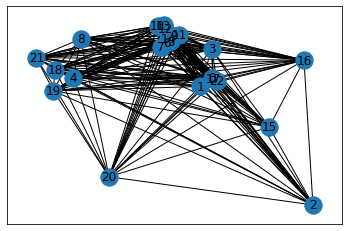

In [247]:
nx.draw_networkx(G, pos=pos)

https://towardsdatascience.com/solving-travelling-salesperson-problems-with-python-5de7e883d847